# Predicting Churn for Sparkify

*This is a Udacity Data Scientist Nanodegree capstone project. And the dataset used in the analysis has been provided by Udacity. This notebook cannot be referenced by Udacity students to complete their capstone projects.*


## About Project

Sparkify is a music streaming app much like spotify. The data set used for this analysis is the user log obtained from this app. The log file contains demographics of users such as gender and activity on the app. The log file however does not  store sensitive user information such as password.

The analysis is done on the log file to understand the user churn (discontinuing the services) and predict if a user is going to churn by using various data science practices and methods.

The notebook tries to display step by step process to reach the end result. The project is built on Spark (pyspark) using  python and primarily uses pyspark modules and function for the analysis. The step by step process for data analysis is followed from loading , cleaning and exploring data to feature engineering , using machine learning models , evaluating the models and selection of the best model for the data. The metric used for evaluating the machine learning model is F1-score the reason for which is provided in the notebook.

## Load and Clean Dataset

The dataset used for this  analysis has been provided by Udacity and is a medium sized  dataset (200mb +) named 
'medium-sparkify-event-data.json'. The dataset is loaded through a spark session and is used in the notebook as a spark dataframe object.

Following cells details the modules required and used in the notebook and imports them. Then initializes a spark session  (might be different  depending on where you are running the notebook for instance AWS or IBM Watson or Local) which loads the data from json to spark dataframe object.

In [404]:
#Importing dependent modules and functions
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, desc, lit, min, max, udf, isnull
from pyspark.sql.types import IntegerType,DoubleType

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from time import time

In [316]:
#Initialize Spark session and change this code to scale up with AWS or IBM
spark = SparkSession.builder.appName("Sparkify-DSND").getOrCreate()
raw_data = 'mini_sparkify_event_data.json'
df = spark.read.json(raw_data)
df.persist()
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [317]:
#check the count and number of columns
df.count(), len(df.take(1)[0])

(286500, 18)

In [318]:
#Number of users
df.select('userId').dropDuplicates().count()

226

Let us see the schema of the data. It seems all the columns are nullable and thus we need to check and clean the data as necessary.

In [319]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [320]:
def set_labels(ax,xlabel,ylabel,title=None):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title is not None :
        ax.set_title(title)

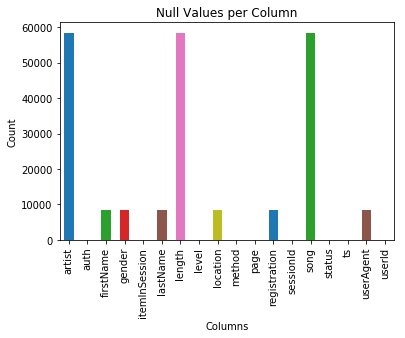

In [321]:
#check the columns for null values
col_null={}
for i in df.columns :
    col_null[i]=df.where(col(i).isNull()).count()
col_null=pd.Series(col_null)
ax=col_null.plot(kind='bar')
set_labels(ax,'Columns','Count','Null Values per Column');

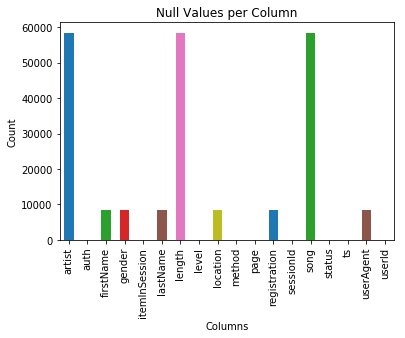

In [322]:
#check the columns for null values
col_null={}
for i in df.columns :
    col_null[i]=df.where(col(i).isNull()).count()
col_null=pd.Series(col_null)
ax=col_null.plot(kind='bar')
ax.set_xlabel('Columns')
ax.set_ylabel('Count')
ax.set_title('Null Values per Column');

As we can see from the above cell a fair number of columns have null values but it seems there is a pattern as number of records which are null seem to be constant for some group of columns. Let us check if any important column such as userId is null  in which case we will remove those records.

In [323]:
#Check if any userId is null 
df.filter(col('userId').isNull()).collect()

[]

In [324]:
df.select('userId').dropDuplicates().sort('userId').show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



Though there are no null values in userId column there seem to be '' (empty string) instead. This could be because of unregistered users browsing the site. These will be filtered as we want to predict churn of registered users.

In [325]:
#Check if there are any null values in userId, sessionId 

df.dropna(how = "any", subset = ["userId", "sessionId"]).count()

286500

In [326]:
#There seems to be userId with '' (empty string) 
#Removing such users
df=df.filter("userId != ''")

In [327]:
#Checking count
df.collect()
df.count()

278154

In [328]:
df.select('userId').dropDuplicates().sort('userId').show(5)

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
+------+
only showing top 5 rows



In [329]:
df.select('sessionId').dropDuplicates().count()

2312

Checking again the null values for all columns

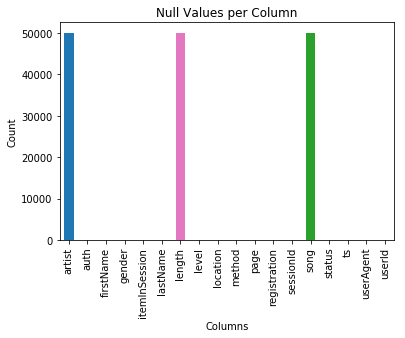

In [330]:
#check the columns for null values
col_null={}
for i in df.columns :
    col_null[i]=df.where(col(i).isNull()).count()
col_null=pd.Series(col_null)
ax=col_null.plot(kind='bar')
set_labels(ax,'Columns','Count','Null Values per Column');

Most of the columns having  null values like  gender, etc are now without any null values. The columns which now have null values like artist seem to be genuine since not all pages in the app play songs like 'Add Friend' and these values will be null in those cases.

It seems the data is fairly clean and EDA can now be performed on it .

## Exploratory Data Analysis

We will do some exploratory analysis of the data to get some preliminary insights from the data.


### Define Churn

We will define churn as people who have decided to stop their services for sparkify be it free or paid. Hence a user is considered a churned users when they have a log with page == 'Cancellation Confirmation' , which basically signifies the information that they have successfully deleted their account from sparkify or discontinued their services.

### Explore Data

Now that we have defined churn we shall perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. 

In [331]:
#log range
#Max and min timestamp
min_ts=df.select('ts').groupby().min('ts').collect()
max_ts=df.select('ts').groupby().max('ts').collect()

In [332]:
min_time= datetime.datetime.fromtimestamp(min_ts[0][0] / 1000.0).strftime("%Y-%m-%d %H:%M:%S")
min_time

'2018-10-01 00:01:57'

In [333]:
max_time= datetime.datetime.fromtimestamp(max_ts[0][0] / 1000.0).strftime("%Y-%m-%d %H:%M:%S")
max_time

'2018-12-03 01:11:16'

The log file has activity records from 1st Oct to 3rd Dec.

Now we will define churn in the dataset. Normally churn is when a user decides to discontinue the services or deletes their account. So for this analysis we will select users who have 'Cancellation Confirmation' page in the log as churned users.


In [334]:
#Check distinct pages that sparkify app has 
df.select("page").dropDuplicates().show(20)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [335]:
#check churn count in the data with Cancellation Confirmation page for both paid and free users
churn_count=df.select(['userId','page']).filter("page=='Cancellation Confirmation'").dropDuplicates().count()
churn_count

52

Let us check the percentage of users churned.

In [336]:
tot_user=df.select('userId').dropDuplicates().count()
per_user_churn=churn_count/tot_user*100
print(per_user_churn)

23.11111111111111


That is about 23% of the users have churned. This is quite a lot of churn and sparkify has to pickup their game  if they want to reduce that number.

In [337]:
#Adding Churn 'label' column to indicate user when downgrading 
users_churned=df.filter(df.page == 'Cancellation Confirmation').select('userId').dropDuplicates().toPandas()
get_churn=udf(lambda x : 'True' if x in users_churned.userId.values else 'False')
df=df.withColumn('label',get_churn(df.userId))
df.collect()
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, label: string]

In [338]:
#count of gender 
gender_count=df.select(['gender','userId']).dropDuplicates().groupby('gender').count().toPandas()

The gender wise distribution of the users seems fairly similar.

Let us check the gender distribution of churn and non-churn users

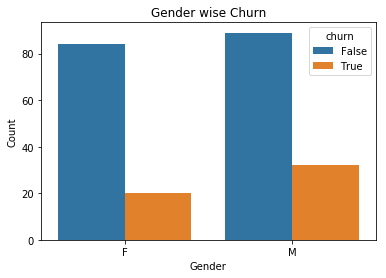

In [339]:
gender_churn=df.select("userId","gender",col("label").alias("churn")).dropDuplicates().groupby(['gender','churn']).count().toPandas()
ax=sns.barplot(x='gender',y='count' ,hue='churn', data=gender_churn)
set_labels(ax,'Gender','Count','Gender wise Churn');

From the plot it seems that there churn is more for Males then Females. One reason could be that the total user count is less and it seems that Males churn is 50 % more than Females. It could be checked if the analysis is done on the full sized data instead of mini or medium sized one.

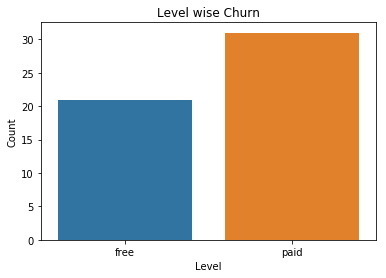

In [340]:
#Checkin churn for level
churn_level = df.filter("page=='Cancellation Confirmation'").select(['level',col('label') \
                .alias('churn')]).groupby('level').count().toPandas()

ax=sns.barplot(x='level',y='count',data=churn_level)
set_labels(ax,'Level','Count','Level wise Churn');

Plot shows that churn is more for paid users then free users which seems to be the logical reason as they might not be happy with the offers or services which come with paid subscription. The thing to note is free users churn is quite high as well, sparkify has to really up their game and provide new offers.

Let us check the pages (except for NextSong) which the users visit grouping by according to churn

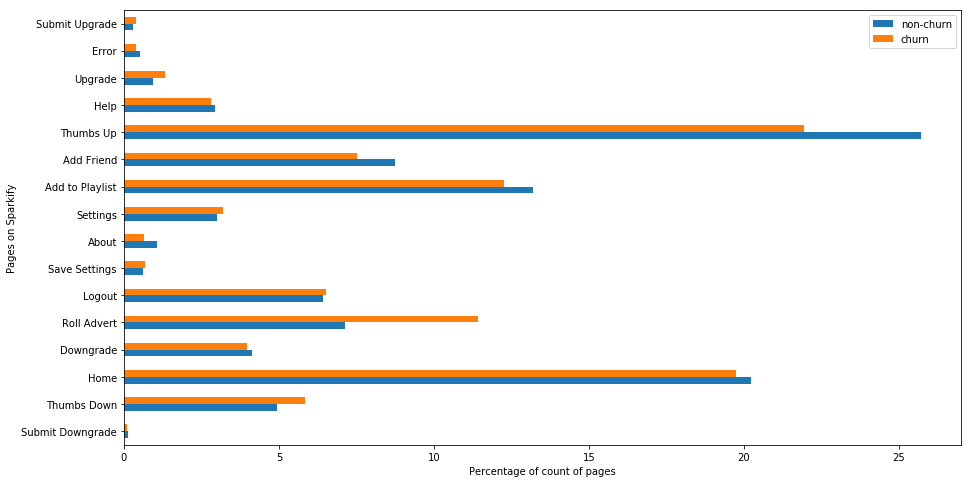

In [341]:
page_count1=df.filter("label=='True' and page != 'NextSong'").groupby('page').count().withColumnRenamed('count','churn').toPandas()
page1_sum=page_count1['churn'].sum()

page_count2=df.filter("label=='False' and page != 'NextSong'").groupby('page').count().withColumnRenamed('count','non-churn').toPandas()
page2_sum=page_count2['non-churn'].sum()

page_count1['churn']=page_count1['churn']/page1_sum*100
page_count2['non-churn']=page_count2['non-churn']/page2_sum*100

page_count=page_count2.merge(page_count1,on='page',how='left')
page_count.set_index(page_count.page,inplace=True)
ax=page_count.plot(kind='barh',figsize=(15,8));
set_labels(ax,'Percentage of count of pages','Pages on Sparkify');

The plot shows that there is difference of percentage for some pages of Churn users. The most drastic difference is for 'Roll Advert' page. Churn users are on this page about 50% more than normal users. This might be one of the main factors for churning as well. Some other pages include 'Thumbs Up', 'Thumbs Down', 'Add Friend','Add Playlist'. 'Thumbs Up' is generally more for normal users than churn users. Whereas 'Thumbs Down' is more for churn users than normal ones. 'Add Friend' and 'Add Playlist' is also lesser for churn users then normal users. 

This seems to be logical as users who are not satisfied with their services loose interest and their activity shows the above pattern.

Since timestamp column is in interger we need to convert it into a more readable format.

In [342]:
#Add time, hour , day column by using ts 
get_time=udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
get_hour=udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%H"))
get_day=udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%a"))

In [343]:
df=df.withColumn('time',get_time(df.ts))
df=df.withColumn('hour',get_hour(df.ts))
df=df.withColumn('day',get_day(df.ts))

In [344]:
#Check sample session of userId =10 
df.select(['userId','time','hour','day','level','sessionId']).where((df.userId=='10') & (df.sessionId == '9')).sort('ts').show(5)

+------+-------------------+----+---+-----+---------+
|userId|               time|hour|day|level|sessionId|
+------+-------------------+----+---+-----+---------+
|    10|2018-10-08 02:20:20|  02|Mon| paid|        9|
|    10|2018-10-08 02:24:45|  02|Mon| paid|        9|
|    10|2018-10-08 02:28:05|  02|Mon| paid|        9|
|    10|2018-10-08 02:31:33|  02|Mon| paid|        9|
|    10|2018-10-08 02:40:19|  02|Mon| paid|        9|
+------+-------------------+----+---+-----+---------+
only showing top 5 rows



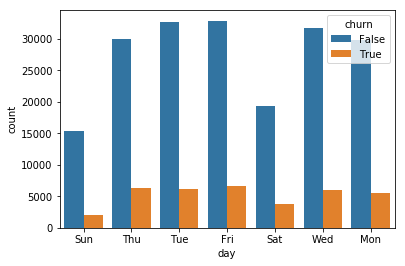

In [345]:
#Check number of songs played on any day of the week
count_song_day=df.filter(df.page=='NextSong').select(['page','day',col('label').alias('churn')]) \
                 .groupby(['day','churn']).count().toPandas()
day_plot=sns.barplot(x="day", y="count", hue="churn", data=count_song_day)
set_labels(ax,'Day of the Week','Count of songs','Count of songs per day of the week');

Users seem to listen more to sparkify during weekdays and considerably less during weekends. This might be because people normally listen to songs during travel to work and during weekends they might be busy doing other activities.

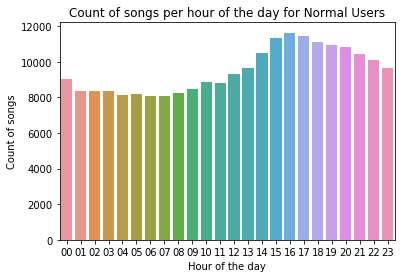

In [346]:
#Check number of songs played on any hour of the day for all users
count_song_hour=df.select(['page','hour']).where(df.page=='NextSong').groupby('hour').count().sort('hour').toPandas()
ax=sns.barplot(x="hour", y="count", data=count_song_hour)
set_labels(ax,'Hour of the day','Count of songs','Count of songs per hour of the day for Normal Users');

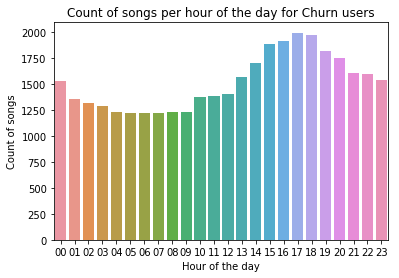

In [347]:
#Check number of songs played on any hour of the day for churn users
churn_song_hour=df.filter("label=='True' and page=='NextSong'").select(['page','hour']).groupby('hour').count().toPandas()
ax=sns.barplot(x='hour',y='count',data=churn_song_hour)
set_labels(ax,'Hour of the day','Count of songs','Count of songs per hour of the day for Churn users');

Distribution of number of songs played at any hour of the day tells us that songs are played the most during the range of 1500 to 2000 hrs. This is the prime time for users of sparkify as they use the application the most during that time.

From the plots of churn and normal users it shows that the distirbution of listening of songs is similar and shows that churned users is not entirely a different category of sparkify users with different listening haibits.

Lets check for the count of average songs played in each session  by user for churn and not-churn

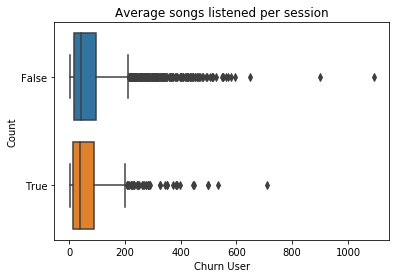

In [348]:
avg_song=df.filter("page=='NextSong'").groupby(['label','userId','sessionId']).count().toPandas()
ax=sns.boxplot(x='count', y='label', orient="h", data=avg_song)
set_labels(ax,'Churn User','Count','Average songs listened per session');

Check when grouped by gender

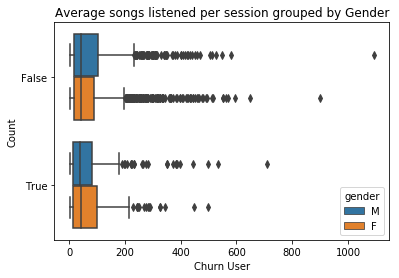

In [349]:
avg_song=df.filter("page=='NextSong'").groupby(['label','userId','sessionId','gender']).count().toPandas()
ax=sns.boxplot(x='count', y='label', orient="h",hue='gender', data=avg_song)
set_labels(ax,'Churn User','Count','Average songs listened per session grouped by Gender');

As per the distribution of average songs played per session  by churn and normal users shows that a churn user has lesser activity in listening to songs. Gender wise distribution shows that Male churn users listen to less number of songs than normal Male users.

The data has also contains location of the users. We can maybe check if the churn is specific to any state. 

Extracting State as a new column and checking the count for churn and normal users.

In [350]:
get_state=udf(lambda x : x.split(',')[-1].strip())

In [351]:
df=df.withColumn('State',get_state(df.location))
df.collect()
df.persist();

In [352]:
count_state=df.select(['userId','label','State']).dropDuplicates().groupby(['label','State']).count().toPandas()
sum_count_state=sum(count_state['count'])
count_state['count']=count_state['count']/sum_count_state*100

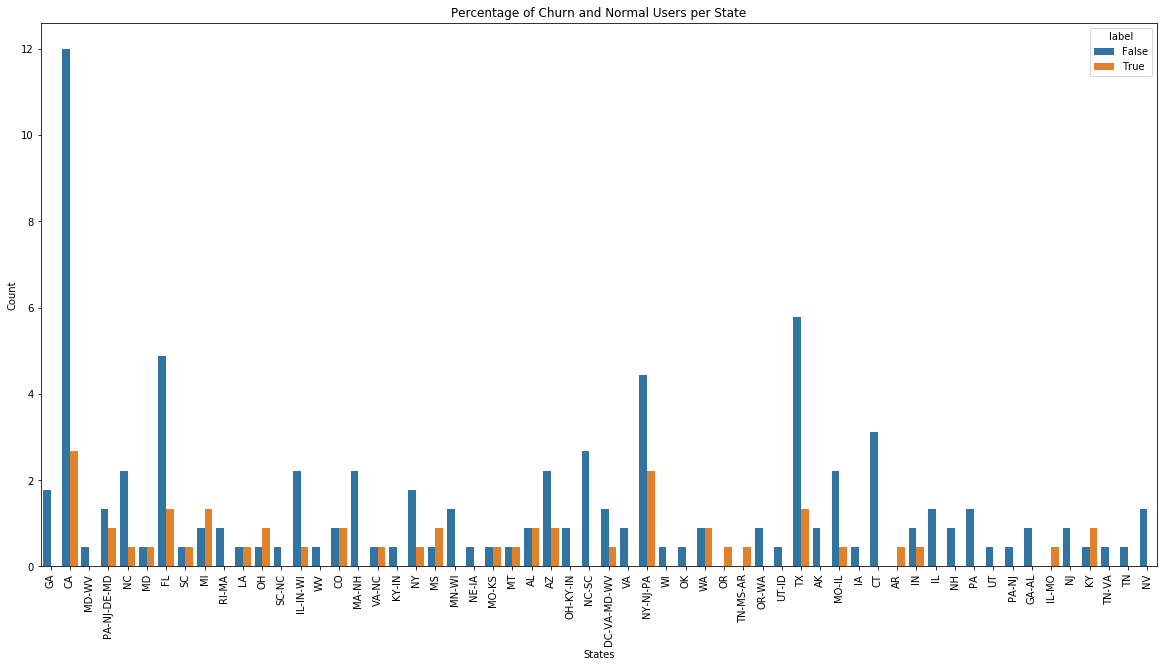

In [353]:
_,ax=plt.subplots(figsize=(20,10))
fig_state=sns.barplot(x='State',y='count',hue='label',data=count_state,ax=ax)
fig_state.set_xticklabels(fig_state.get_xticklabels(), rotation=90);
set_labels(fig_state,'States','Count','Percentage of Churn and Normal Users per State');


The distribution for state shows that most of the users may be from 'CA' as it has the highest percentage of users about 12%. There are some states where churn rate is higher then the normal users retention rate. These states are  'AR','KY','IL-MO','CH' etc. These states are where sparkify maybe should increase their markteing and provide more offers.

Let us see for the total life of a user the plot of churn

In [354]:
tot_life=df.select(['userId','registration','ts']).groupby(['userId','registration']).max('ts').withColumnRenamed('max(ts)','ts')
tot_life=tot_life.withColumn('tot_life',((tot_life.ts-tot_life.registration)/1000/3600/24)).select(['userId','tot_life'])

In [355]:
tot_life.collect()
tot_life.persist()

DataFrame[userId: string, tot_life: double]

In [356]:
tot_life = tot_life.join(df.select('userId','label').dropDuplicates(),'userId','outer').toPandas()

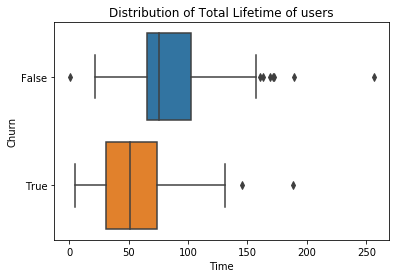

In [357]:
ax=sns.boxplot(x='tot_life', y='label', orient="h", data=tot_life)
set_labels(ax,'Time','Churn','Distribution of Total Lifetime of users');

IT seems that on average total time is less for churned users and users tend to churn more when they have recently subscribed to the service

# Feature Engineering
We will now try and build out the features that aere promising to train the model on.


Below are some of the variables which I think might be good for the model:
1. 'tot_num_song':This feature tells us the sum of all songs listened by a user in the log file
2. 'tot_num_session': This feature tells the number of times a user has logged in during the span of the log file
3. 'avg_song_per_sess': This feature tells the average number of songs that a user listens during one session
4. 'tot_life': This is the total amount of time ,starting from registration till the last entry of the user in log file, the user has been with sparkify
5. 'tot_artist': This feature tells about the total number of different artists that a user has listened to till now
6. 'thumbs_up': This feature tells how many thumbs up a user has given in the log file
7. 'thumbs_down': This feature tells how many thumbs down a user has given in the log file
8. 'downgrade': This feature tells if the user downgraded their services from paid to free
9. 'upgrade': This feature tells if the user upgraded their services from free to paid
10. 'add_friends': This feature tells the amount of friends a user has 
11. 'add_song': This feature tells the amount of songs user likes enough to be on their playlist
12. 'gender': This feature tells the gender of the user
13. 'level': This feature tells the level the user is currently at either paid or free

Now that we have defined the features , we will start extracting them from the data

In [358]:
features=['tot_num_song','tot_num_session','avg_song_per_sess','tot_life','tot_artist','thumbs_up',
          'thumbs_down','downgrade','upgrade','add_friends','add_song','gender','level']

*1. Total number of songs per user*

In [359]:
#feature for tot_num_song per user
f0=df.filter("page== 'NextSong'").select('userId').groupby('userId').count()
f0=f0.withColumnRenamed('count','tot_num_song')

*2. Total number of sessions per user*

In [360]:
#feature for tot_num_session
f1=df.select(['userId','sessionId']).dropDuplicates().groupby('userId').count()
f1=f1.withColumnRenamed('count','tot_num_session')


*3. Average song per session per user*

In [361]:
#feature for avg_song_per_sess
f2=df.filter("page== 'NextSong'").select(['userId','sessionId']).groupby(['userId','sessionId']).count().groupby(['userId']).agg({'count':'avg'})
f2=f2.withColumnRenamed('avg(count)','avg_song_per_sess')


*4.Total time user has been with sparkify*

In [362]:
#feature for tot_life
f3=df.select(['userId','registration','ts']).groupby(['userId','registration']).max('ts').withColumnRenamed('max(ts)','ts')
f3=f3.withColumn('tot_life',((f3.ts-f3.registration)/1000/3600/24)).select(['userId','tot_life'])

*5. Nuber of different artists a uers has listened*

In [363]:
#feature for tot_artist
f4=df.filter("page=='NextSong'").select(['userId','artist']).dropDuplicates().groupby('userId').count()
f4=f4.withColumnRenamed('count','tot_artist')

*6. Total number of thumbs up has a user given*

In [364]:
#feature for thumbs_up
f5=df.filter("page == 'Thumbs Up'").select(['userId']).groupby('userId').count()
f5=f5.withColumnRenamed('count','thumbs_up')

*7. Total number of thumbs down has a user given*

In [365]:
#feature for thumbs_down
f6=df.filter("page == 'Thumbs Down'").select(['userId']).groupby('userId').count()
f6=f6.withColumnRenamed('count','thumbs_down')

*8. & 9.  Has a user downgraded or upgraded within the duration of log file*

In [366]:
recent_upg_dwg=df.filter("page== 'Submit Downgrade' or page== 'Submit Upgrade'") \
                 .select(['userId','page','ts']).groupby(['userId','page']).max('ts')
recent_upg_dwg.collect();

In [367]:

user_downgrade=recent_upg_dwg.filter("page=='Submit Downgrade'").select('userId').toPandas()
user_upgrade=recent_upg_dwg.filter("page=='Submit Upgrade'").select('userId').toPandas()
get_downgrade=udf(lambda x: 1 if x in user_downgrade.userId.values else 0)
get_upgrade=udf(lambda x: 1 if x in user_upgrade.userId.values else 0)

In [368]:
#feature for downgrade
f7=df.select('userId').dropDuplicates()
f7=f7.withColumn('downgrade',get_downgrade(f7.userId))

In [369]:
#feature for upgrade
f8=df.select('userId').dropDuplicates()
f8=f8.withColumn('upgrade',get_upgrade(f8.userId))

*10. Number of friends a user has added*

In [370]:
#feature for add_friends
f9=df.filter("page == 'Add Friend'").select(['userId']).groupby('userId').count()
f9=f9.withColumnRenamed('count','add_friends')

*11. Number of songs a user has added in their playlist*

In [371]:
#feature for add_song
f10=df.filter("page == 'Add to Playlist'").select(['userId']).groupby('userId').count()
f10=f10.withColumnRenamed('count','add_song')

*12. Gender of the user*

In [372]:
#feature for gender 
get_gender_int=udf(lambda x : 1 if  x == 'M' else 0)
f11=df.select(['userId','gender']).dropDuplicates()
f11= f11.withColumn('gender_int',get_gender_int(f11.gender)).select(['userId','gender_int']).withColumnRenamed('gender_int','gender')

*13. Latest level of the user*

In [373]:
#feature for level
f12=df.select(['userId','ts']).groupby('userId').max('ts').withColumnRenamed('max(ts)','ts').dropDuplicates()
f12=f12.join(df.select(['userId','ts','level']).dropDuplicates(),['userId','ts'],'left_outer')
get_level = udf(lambda x : 1 if x == 'paid' else 0)
f12=f12.withColumn('level_int',get_level(f12.level)).select("userId",col('level_int').alias('level'))

*14. Churn indicator for user*

In [374]:
#label for churn
label=df.select(['userId','label']).dropDuplicates()

In [375]:
#Collecting all the features
f0.collect()
f1.collect()
f2.collect()
f3.collect()
f4.collect()
f5.collect()
f6.collect()
f7.collect()
f8.collect()
f9.collect()
f10.collect()
f11.collect()
f12.collect()
f11.count()

225

In [376]:
#Joining them to form the final feature table 
f= f11.join(f12,'userId','outer')\
    .join(f10,'userId','outer')\
    .join(f9,'userId','outer')\
    .join(f8,'userId','outer')\
    .join(f7,'userId','outer')\
    .join(f6,'userId','outer')\
    .join(f5,'userId','outer')\
    .join(f4,'userId','outer')\
    .join(f3,'userId','outer')\
    .join(f2,'userId','outer')\
    .join(f1,'userId','outer')\
    .join(f0,'userId','outer')\
    .join(label,'userId','outer')\
    .drop('userId')\
    .fillna(0)

In [377]:
f.collect()
f.persist()
f.count()

225

In [378]:
f.printSchema()

root
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- add_song: long (nullable = true)
 |-- add_friends: long (nullable = true)
 |-- upgrade: string (nullable = true)
 |-- downgrade: string (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- tot_artist: long (nullable = true)
 |-- tot_life: double (nullable = false)
 |-- avg_song_per_sess: double (nullable = false)
 |-- tot_num_session: long (nullable = true)
 |-- tot_num_song: long (nullable = true)
 |-- label: string (nullable = true)



Since most of the features are numeric converting them to type double and mapping integer values for label

In [379]:
#Map label column to integer values
get_label_int=udf(lambda x : 1 if x == 'True' else 0)
f=f.withColumn('label_int',get_label_int(f.label)).drop('label').withColumnRenamed('label_int','label')
f.collect()
f.persist();

In [380]:
#Convert all columns to data type double
for col in features :
    f=f.withColumn(col,f[col].cast(DoubleType()))
f=f.withColumn('label',f.label.cast(DoubleType()))
f.collect()
f.persist()
f.take(1)

[Row(gender=0.0, level=0.0, add_song=7.0, add_friends=4.0, upgrade=0.0, downgrade=0.0, thumbs_down=5.0, thumbs_up=17.0, tot_artist=252.0, tot_life=55.6436574074074, avg_song_per_sess=39.285714285714285, tot_num_session=7.0, tot_num_song=275.0, label=0.0)]

We now have our final features file which we can save and reload later to do training 

In [381]:
file_name ='final_features_data.json'

In [382]:
if file_name not in  os.listdir():
    f.write.save(file_name,format='json',header=True)

Checking and reading the file final_features_data.json 

In [454]:
if file_name in os.listdir():
    f=spark.read.json(file_name)

In [455]:
f.count()

225

# Modeling

Now that our features are ready we will now start to build and train the model. The model will use the features engineered above and machine learning techniques to predict if a user is about to churn. Model will be judged on F1-score as the metric. F1-score is selected as the data set is skewed and we have very less number of churn users in the dataset. 

We will use sparks ML to apply the machine learning modules. 

Since in pyspark the machine learning techniques need data in vectorized format we will use VectorAssembler to assemble all features into a vector

In [456]:
# Vector assembler
cols = ['tot_num_song','tot_num_session','avg_song_per_sess','tot_life','tot_artist','thumbs_up',
          'thumbs_down','downgrade','upgrade','add_friends','add_song','gender','level']
vec_asm = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
f = vec_asm.transform(f)
f.collect()
f.take(1)

[Row(add_friends=19.0, add_song=23.0, avg_song_per_sess=47.1, downgrade=1.0, gender=0.0, label=0.0, level=1.0, thumbs_down=11.0, thumbs_up=35.0, tot_artist=733.0, tot_life=172.44008101851853, tot_num_session=21.0, tot_num_song=942.0, upgrade=1.0, NumFeatures=DenseVector([942.0, 21.0, 47.1, 172.4401, 733.0, 35.0, 11.0, 1.0, 1.0, 19.0, 23.0, 0.0, 1.0]))]

There are many features such as total songs which have a high range of values. This will cause our model to be biased. To avoid this  we will scale our models with StandardScaler

In [457]:
scl = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scale = scl.fit(f)
f = scale.transform(f)
f.collect()
f.take(1)

[Row(add_friends=19.0, add_song=23.0, avg_song_per_sess=47.1, downgrade=1.0, gender=0.0, label=0.0, level=1.0, thumbs_down=11.0, thumbs_up=35.0, tot_artist=733.0, tot_life=172.44008101851853, tot_num_session=21.0, tot_num_song=942.0, upgrade=1.0, NumFeatures=DenseVector([942.0, 21.0, 47.1, 172.4401, 733.0, 35.0, 11.0, 1.0, 1.0, 19.0, 23.0, 0.0, 1.0]), features=DenseVector([0.8525, 1.4338, 1.1052, 4.5787, 1.2137, 0.5345, 0.8411, 2.4175, 2.0231, 0.9231, 0.703, 0.0, 2.0844]))]

We now have features column which is a dense vector of scaled features. This will now be used to train the model.

Splitting the data set into train , test and validation sets which will be used for training , testing and validation of the model

In [462]:
# train, valid, test split
train, test_val = f.randomSplit([0.6, 0.4], seed=17)
valid, test = test_val.randomSplit([0.5, 0.5], seed=17)

Now that we have the data ready for training. We will now setup a base model on which our trained models will be compared.

**Base Model**

Since we have a skewed data set with less churn users we can directly predict that no users will churn. And hence setting the prediction variable as 0 for the test set . After that we will check the F1 score for the base model and  compare it with the trained models

In [463]:
#setting prediction column as 0
base_pred=test.withColumn('prediction',lit(0.0))
base_pred.collect()
base_pred.take(1)

[Row(add_friends=0.0, add_song=0.0, avg_song_per_sess=3.0, downgrade=0.0, gender=1.0, label=0.0, level=0.0, thumbs_down=0.0, thumbs_up=0.0, tot_artist=3.0, tot_life=0.31372685185185184, tot_num_session=1.0, tot_num_song=3.0, upgrade=0.0, NumFeatures=SparseVector(13, {0: 3.0, 1: 1.0, 2: 3.0, 3: 0.3137, 4: 3.0, 11: 1.0}), features=SparseVector(13, {0: 0.0027, 1: 0.0683, 2: 0.0704, 3: 0.0083, 4: 0.005, 11: 2.0013}), prediction=0.0)]

In [464]:
# Getting F1 score for the base model
evaluator= MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(base_pred.select('label','prediction'),{evaluator.metricName: 'f1'})

0.6736596736596737

In [465]:
def predict_eval(model, data):
    '''
    input : model : trained model which has to be evaluated
            data : data on which model has to be evaluated
    output : f1_score :  float ,returns f1_score for the model
    '''
    pred=model.transform(data)
    f1_score=evaluator.evaluate(pred,{evaluator.metricName: 'f1'})
    return f1_score

Now that we have our F1 score for the base model. We will start to train different ML models on the train. They will be predicting the lables for valid set and the best model amongst that will be selected to be run for test data.

In [466]:
def train_eval_model_def_param (model_list):
    '''
    input: list of models to be trained using default params
    
    The function loops through each model , initializes , trains, predicts and evaluates them. It prints out f1 score
    and time taken for training with default params
    '''
    #Looping through each model
    for k,v in models.items() :
        mod=v #Initializing the model
        start_time = time()
        mod_trained=mod.fit(train) #training the model
        end_time = time()
        f1_score=predict_eval(mod_trained,valid)
        tot_time=end_time-start_time
        print ("F1-Score for {} is {:.4f} with total time taken {:.2f} seconds".format(k,f1_score,tot_time))

In [467]:
models={'Logistic Regression': LogisticRegression(),
        'Decision Tree Classifier': DecisionTreeClassifier(),
        'Random Forest Classifer' : RandomForestClassifier(),
        'Gradient Boosted Tress' : GBTClassifier(),
        'Support Vector Machines' : LinearSVC()}

train_eval_model_def_param(models)

F1-Score for Logistic Regression is 0.6429 with total time taken 3.72 seconds
F1-Score for Decision Tree Classifier is 0.6962 with total time taken 1.32 seconds
F1-Score for Random Forest Classifer is 0.7450 with total time taken 1.22 seconds
F1-Score for Gradient Boosted Tress is 0.6962 with total time taken 11.35 seconds
F1-Score for Support Vector Machines is 0.6144 with total time taken 52.38 seconds


From the result of initial default param run it seems that even though Random forest is clearly the winner but it might have over fitted to the data since the number of users is less. At the same time models like Logistic Regression and decision trees seem promising as the time taken is considerably  less for the F1 score.

Thus we will select Logistic Regression, Decision Tree Classifier and Random Forest Classifier for optimization using 3 fold cross validation. Moels Gradient Boosted trees and Support vector machines take too much time compared to the rest, but with more data and processers this could change. So for now we will not consider these two  models.

In [487]:
#Checking numTrees for Random Forest 
check_rf=RandomForestClassifier()
check_rf_model=check_rf.fit(train)
check_rf_model.trees

[DecisionTreeClassificationModel (uid=dtc_9fca1753c8ae) of depth 5 with 15 nodes,
 DecisionTreeClassificationModel (uid=dtc_12cd6c4d2129) of depth 3 with 11 nodes,
 DecisionTreeClassificationModel (uid=dtc_8037874a6b31) of depth 4 with 11 nodes,
 DecisionTreeClassificationModel (uid=dtc_86d36f4e7403) of depth 5 with 29 nodes,
 DecisionTreeClassificationModel (uid=dtc_a361f1320218) of depth 5 with 15 nodes,
 DecisionTreeClassificationModel (uid=dtc_061ded07e870) of depth 5 with 25 nodes,
 DecisionTreeClassificationModel (uid=dtc_173e06f2fef7) of depth 5 with 21 nodes,
 DecisionTreeClassificationModel (uid=dtc_f160588a6540) of depth 5 with 19 nodes,
 DecisionTreeClassificationModel (uid=dtc_21091d950d0b) of depth 5 with 25 nodes,
 DecisionTreeClassificationModel (uid=dtc_ba18c645ccaf) of depth 5 with 23 nodes,
 DecisionTreeClassificationModel (uid=dtc_b93ae6e1c263) of depth 5 with 15 nodes,
 DecisionTreeClassificationModel (uid=dtc_22ba4f8e92d8) of depth 5 with 27 nodes,
 DecisionTreeCla

Looking at trees parameter for Random Forest as it has 20 trees ,it seems as the number of users is less it might have overfitted the data. We will limit the numTrees hyperparameter while optimization.

**1. Logistic Regression**

In [476]:
lr=LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.01, 0.05, 0.1]) \
    .addGrid(lr.aggregationDepth,[2,3,4]) \
    .build()

cv_lr =CrossValidator(estimator=lr,
                   estimatorParamMaps=paramGrid,
                   evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                   numFolds=3)

start_time = time()
cv_lr_model = cv_lr.fit(train)
end_time = time()

In [477]:
#Predicting and evaluating
predict_eval(cv_lr_model,valid)

0.6939443535188217

In [478]:
#total time taken for the trainin  for Logistic regression
end_time -start_time

392.9072926044464

In [479]:
#Printing the best params
best_model=cv_lr_model.bestModel
print("AggregationDepth: {}".format(best_model._java_obj.getAggregationDepth()))
print("ElasticNetParam: {}".format(best_model._java_obj.getElasticNetParam()))
print("RegParam: {}".format(best_model._java_obj.getRegParam()))

AggregationDepth: 2
ElasticNetParam: 0.0
RegParam: 0.01


**2. Decision Tree Classifier**

In [468]:
dtree = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dtree.impurity,['entropy','gini']) \
    .addGrid(dtree.maxDepth,[ 5, 7, 8,10,12]) \
    .build()

cv_dt = CrossValidator(estimator=dtree,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)
start_time=time()
cv_dt_model = cv_dt.fit(train)
end_time=time()
predict_eval(cv_dt_model,valid)

0.7122060470324748

In [469]:
#Total time for training 
end_time -start_time


31.90830421447754

In [470]:
#Printing the best params
best_model=cv_dt_model.bestModel
print("MaxDepth: {}".format(best_model._java_obj.getMaxDepth()))
print("MaxDepth: {}".format(best_model._java_obj.getImpurity()))

MaxDepth: 5
MaxDepth: entropy


**3. Random Forest**

In [471]:
rfor = RandomForestClassifier()

paramGrid = ParamGridBuilder() \
            .addGrid(rfor.numTrees,[5, 10]) \
            .addGrid(rfor.maxDepth,[2,4,5, 7, 8]) \
            .build()

cv_rf = CrossValidator(estimator=rfor,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)
start_time=time()
cv_rf_model = cv_rf.fit(train)
end_time=time()
predict_eval(cv_rf_model,valid)

0.7122060470324748

In [472]:
#total training time
end_time -start_time 

31.850939750671387

In [473]:
#Printing the best params
best_model=cv_rf_model.bestModel
print("MaxDepth: {}".format(best_model._java_obj.getMaxDepth()))
print("NumTrees: {}".format(best_model._java_obj.getNumTrees()))

MaxDepth: 5
NumTrees: 5


**Evaluating on Test Set**

It seems although there is some improvement  in Logistic Regression Model and Decision Tree Model but it is not much. And score of Random Forest model has reduced due to constricting the numTrees parameter. Thus it should have avoided overfitting. 

Since scores for Random Forest and Decision Trees are similar Testing both on the Test set.

In [485]:
#Evaluating for Random Forest 
predict_eval(cv_rf_model,test)

0.8302327332981848

In [486]:
#Evaluating for Decision Trees 
predict_eval(cv_dt_model,test)

0.74993006993007

From this it seems Random Forest is the clear winner and followed by Decision Trees. Random forest did cosiderably well with an F1 score of 0.83 when comparing to the base model score of about  0.67. This will greatly help Sparkify to more accurately predict churn and direct offers to more appropriate individuals.

**Feature Importance**

Lets try and look at which features have more weight during prediction with the help of featureImportances parameter from the model.

In [488]:
#Checking the feature importance for Random Forest Classifier
rf=RandomForestClassifier(maxDepth=5,numTrees=5)

rf_model=rf.fit(train)

In [489]:
rf_model.featureImportances

SparseVector(13, {0: 0.1168, 1: 0.0683, 2: 0.0965, 3: 0.2426, 4: 0.073, 5: 0.0904, 6: 0.1188, 9: 0.1283, 10: 0.0345, 11: 0.0264, 12: 0.0043})

Interesting,it seems the model has not attached any importance to features 'downgrade' and 'upgrade'. Let us plot the remaining features and understand their weight.

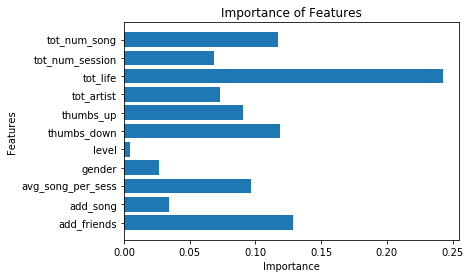

In [490]:
feat_val=rf_model.featureImportances.values
cols_im = ['tot_num_song','tot_num_session','avg_song_per_sess','tot_life','tot_artist','thumbs_up',
          'thumbs_down','add_friends','add_song','gender','level']
plt.barh(cols_im, feat_val)
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Importance of Features');

It can be seen from the plot that Total Life of the user is the biggest factor by far for user Churn prediction. It seems that users tend to churn more when they have joined more recently. Which makes sense as you would mostly find out if you are not liking the service after using for a short period of time. Following total life are the features like Thumbs Down , Total Number of Songs , Add Friends , etc. which also have a high weight.

**Results**

1. As per the base model which we had defined it had a F1-score of 0.67 and our best model which is Random Forest Classifier has F1-score of 0.83. This is a huge improvement if you consider the greater picture and would save a lot of money for Sparkify.
2. Initially out of the five models which we selected and did an initial training with default hyperparams which helped us in eliminating two of those models (GBT , SVM )due to time and score constraints . This could be avoided if we scaled the project on cloud and had a larger data set. That being said the rest of the models did considerably well in terms of both time and metric and hence were selected for optimization.
3. After the optimization all the models were quite close in the scores and hence were selected for final test set. And finally it was Random Forest Classifier which came out in top with the highest F1 score of 0.83 ,which was unexpected since it had overfit the data and the score reduced during optimization. It also had a very modest training time compared to all other models which makes it a perfect match for scaling.